# Macroeconomic dashboard

Alex Wellman, October 2023

In [134]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import imgkit

In [128]:
def calculate_yoy(df):
    # Calculate the Year-over-Year percentage change
    df_yoy = df.pct_change(periods=12) * 100
    return df_yoy

In [137]:
def fetch_and_plot(url_template, countries, plot_title, frequency, x_label, y_label):
    # Create an empty DataFrame to store the results
    df_collect = pd.DataFrame()

    # Initialize a list to store DataFrame rows for the summary table
    summary_rows = []

    # Loop through the countries and extract data
    for country_code, country_name in countries.items():
        # Format the URL with the country code
        url = url_template.format(country_code=country_code)
        response = requests.get(url)

        # Check if the data is found for the country
        if response.status_code != 200:
            print(f"Data not found for {country_name} ({country_code}).")
            continue

        df_country = pd.read_csv(StringIO(response.text), sep='\t')

        # Select the data column assuming it's the second one
        data_columns = df_country.columns[1:]

        # Append the data for the current country to the main DataFrame
        df_collect[country_name] = df_country[data_columns].iloc[0]

    # Replace ':' and any trailing spaces with NaN for missing values
    df_collect.replace(': ?', pd.NA, regex=True, inplace=True)

    # Ensure that the index is a string and strip any whitespace that might cause parsing issues
    df_collect.index = df_collect.index.astype(str).str.strip()

    # Convert index to DateTime
    if frequency == 'Q':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='Q').to_timestamp()
    elif frequency == 'M':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='M').to_timestamp()

    # Replace '<NA>' with np.nan and remove ' p' from the data
    df_collect = df_collect.replace({ '<NA>': np.nan, ' p': '' }, regex=True)

    # Convert the index to a datetime format if it's not already
    df_collect.index = pd.to_datetime(df_collect.index)

    # Filter the DataFrame to include data from 1995 onwards
    df_collect = df_collect[df_collect.index.year >= 1995]

    # Convert all data to numeric, coercing errors to NaN
    for column in df_collect.columns:
        df_collect[column] = pd.to_numeric(df_collect[column], errors='coerce')

    # Calculate YoY percentage change if required
    if plot_title.startswith("HICP YoY"):
        df_collect = calculate_yoy(df_collect)

    # Accumulate data for summary table
    for country in df_collect.columns:
        recent_data = df_collect[country].dropna()
        if not recent_data.empty:
            recent_date = recent_data.index[-1]
            recent_value = recent_data.iloc[-1]
            previous_year_date = recent_date - pd.DateOffset(years=1)
            previous_year_value = df_collect[country].get(previous_year_date, "N/A")

            # Add a new row to the summary_rows list
            summary_rows.append({
                "Country": country,
                "Most Recent Date": recent_date.date(),
                "Most Recent Value": recent_value,
                "Previous Year Date": previous_year_date.date(),
                "Previous Year Value": previous_year_value
            })

    # Create the summary DataFrame using concat
    summary_table = pd.concat([pd.DataFrame([row]) for row in summary_rows], ignore_index=True)

    # Styling the DataFrame for a cleaner look
    styled_table = summary_table.style.set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}]
    ).hide(axis='index').set_caption(f"<b style='font-size: 16pt;'>{plot_title}</b>")

    # Display the styled table
    display(styled_table)

    # Save the table as PNG
    table_html = styled_table.to_html()
    table_filename_html = f"/Users/awellman/Documents/GitHub/macrodata-wellman/figures/{plot_title.replace(' ', '_')}_table.html"
    table_filename_png = f"/Users/awellman/Documents/GitHub/macrodata-wellman/figures/{plot_title.replace(' ', '_')}_table.png"
    with open(table_filename_html, 'w') as f:
        f.write(table_html)
    
    # Convert HTML to PNG using imgkit
    imgkit.from_file(table_filename_html, table_filename_png)

    # Plotting
    plt.figure(figsize=(14, 7))
    for column in df_collect.columns:
        plt.plot(df_collect.index, df_collect[column], label=column)

    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save the plot as PNG
    plot_filename = f"/Users/awellman/Documents/GitHub/macrodata-wellman/figures/{plot_title.replace(' ', '_')}_plot.png"
    plt.savefig(plot_filename)
    plt.close()

In [131]:
# Define your countries dictionary
countries = {
    'FR': 'France',
    'DE': 'Germany',
    'IT': 'Italy',
    'EA': 'Euro Area',
    'UK': 'UK'
}

In [132]:
# Legend
    # SCA = seasonally and calendar adjusted
    # PCH_SM = Percentage change compared to same period in previous year 
    # Q = Quarterly
    # M = Monthly
    # PC_ACT = Percentage of active population (Labor Force)

urls_and_titles = [
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/namq_10_lp_ulc/Q.I10.SCA.RLPR_HW.{country_code}?format=TSV", #url
        "Labor Productivity Per Hour Worked", #title
        'Q', #frequency of data 
        "Time", #x_label
        "" #y_label
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/namq_10_lp_ulc/Q.I10.SCA.RLPR_Per.{country_code}?format=TSV",
        "Labor Productivity Per Person Employed",
        'M',
        "Time", 
        "Productivity Per Employed Person"
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-TOT.{country_code}?format=TSV", 
        "Overall Unemployment Rate (%)",
        'M',
        "Time", 
        "Overall Unemployment Rate (%)"
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/prc_hicp_midx/M.I05.CP00.{country_code}?format=TSV",
        "HICP YoY Change (%)",
        'M',
        "Time",
        "HICP YoY Change (%)"
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-LE25.{country_code}?format=TSV", 
        "Youth Unemployment Rate (%)",
        'M',
        "Time", 
        "Youth Unemployment Rate (%)"
    ),
]

Country,Most Recent Date,Most Recent Value,Previous Year Date,Previous Year Value
France,2023-04-01,102.941000,2022-04-01,103.887000
Germany,2023-04-01,110.434000,2022-04-01,111.815000
Italy,2023-04-01,101.687000,2022-04-01,102.807000
Euro Area,2022-10-01,109.353000,2021-10-01,109.810000
UK,2020-07-01,107.500000,2019-07-01,103.400000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


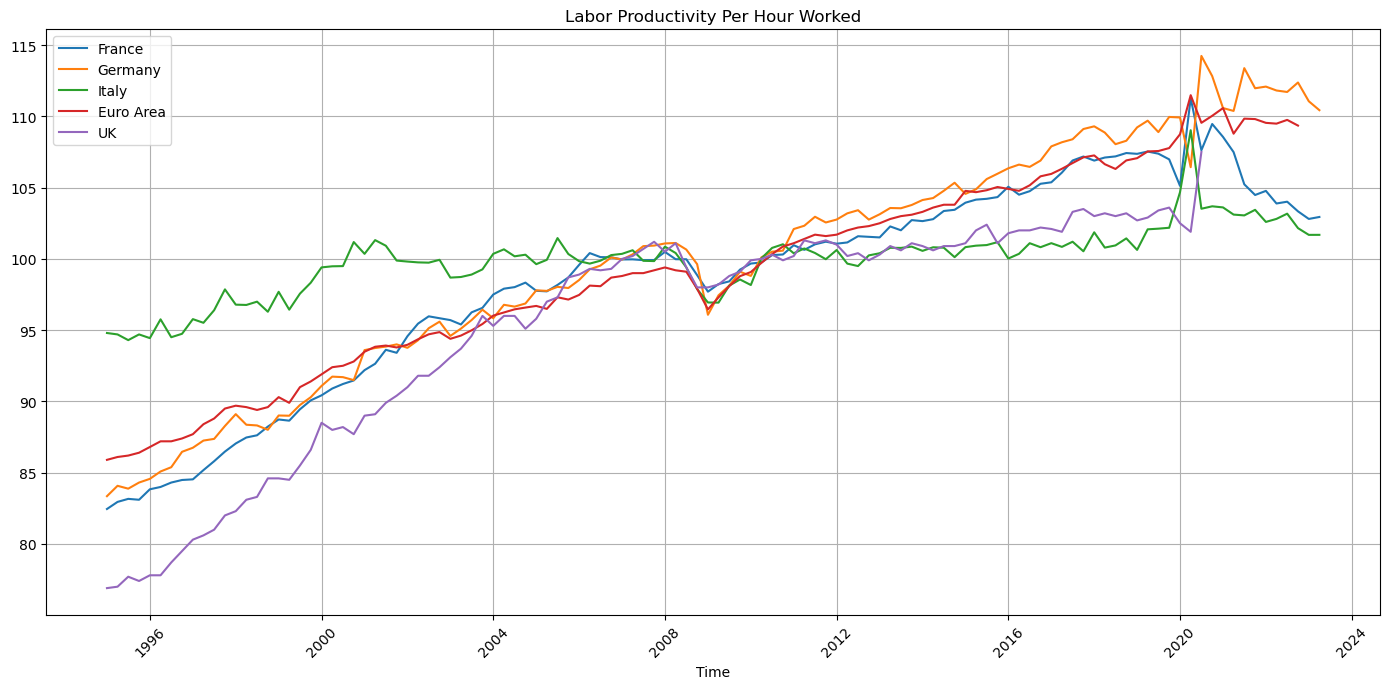

Country,Most Recent Date,Most Recent Value,Previous Year Date,Previous Year Value
France,2023-07-01,101.498000,2022-07-01,101.828000
Germany,2023-07-01,104.977000,2022-07-01,106.147000
Italy,2023-07-01,98.813000,2022-07-01,100.638000
Euro Area,2022-10-01,104.795000,2021-10-01,104.528000
UK,2020-07-01,96.800000,2019-07-01,105.100000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


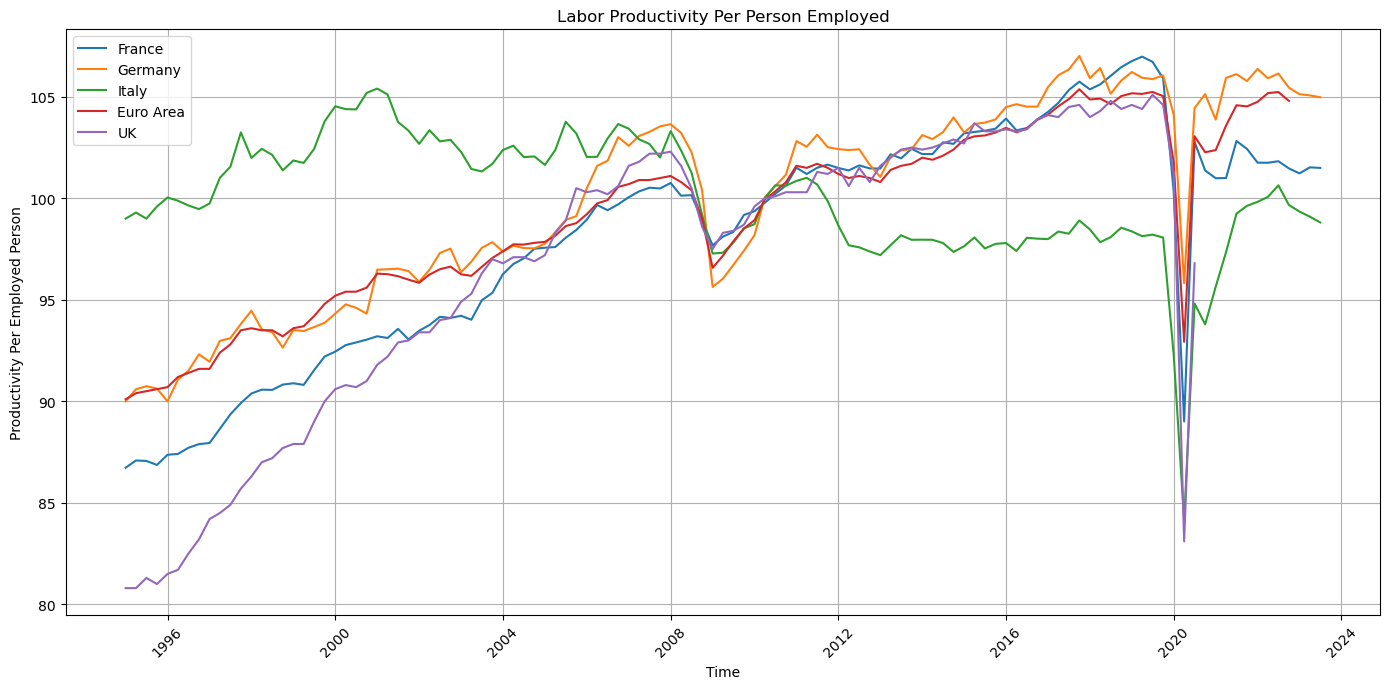

Data not found for Euro Area (EA).


Country,Most Recent Date,Most Recent Value,Previous Year Date,Previous Year Value
France,2023-09-01,7.300000,2022-09-01,7.100000
Germany,2023-09-01,3.000000,2022-09-01,3.100000
Italy,2023-09-01,7.400000,2022-09-01,8.000000
UK,2020-09-01,4.900000,2019-09-01,3.700000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


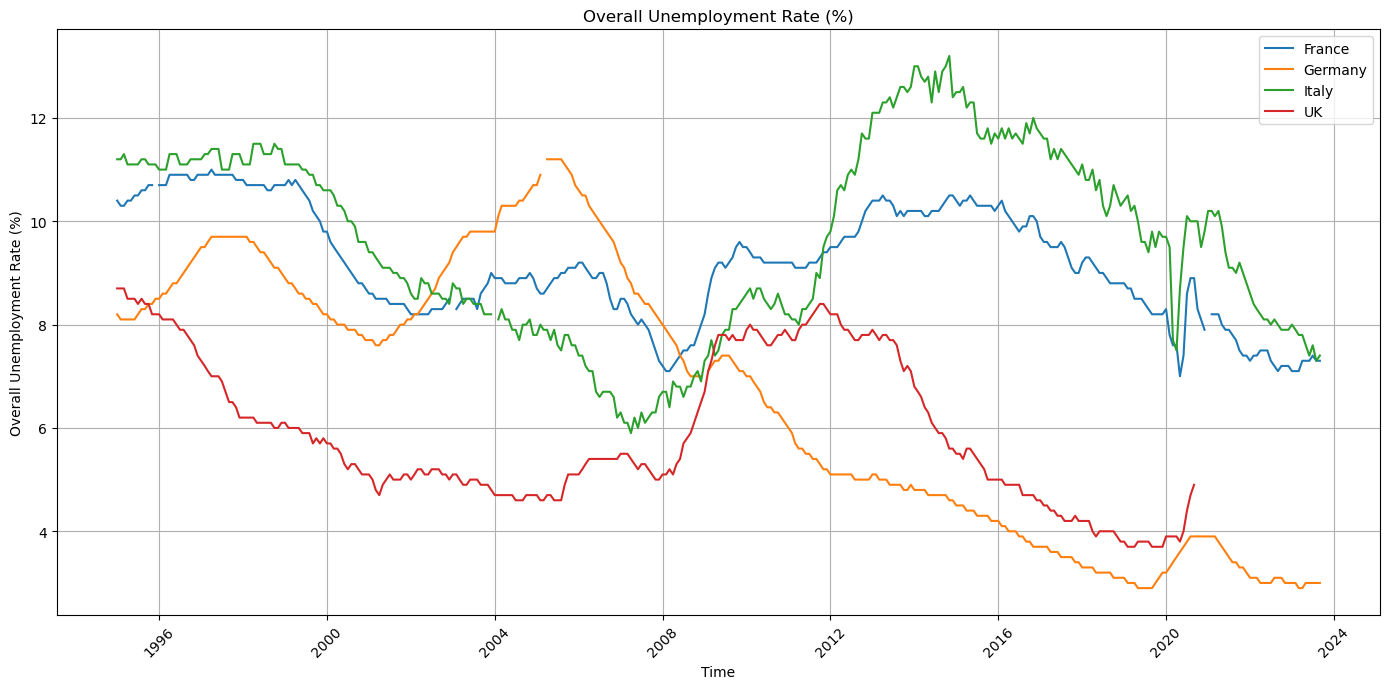

Country,Most Recent Date,Most Recent Value,Previous Year Date,Previous Year Value
France,2023-10-01,4.363339,2022-10-01,7.075772
Germany,2023-10-01,3.042877,2022-10-01,11.574074
Italy,2023-10-01,1.814375,2022-10-01,12.480377
Euro Area,2023-10-01,2.802102,2022-10-01,10.624613
UK,2023-10-01,0.000000,2022-10-01,0.000000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


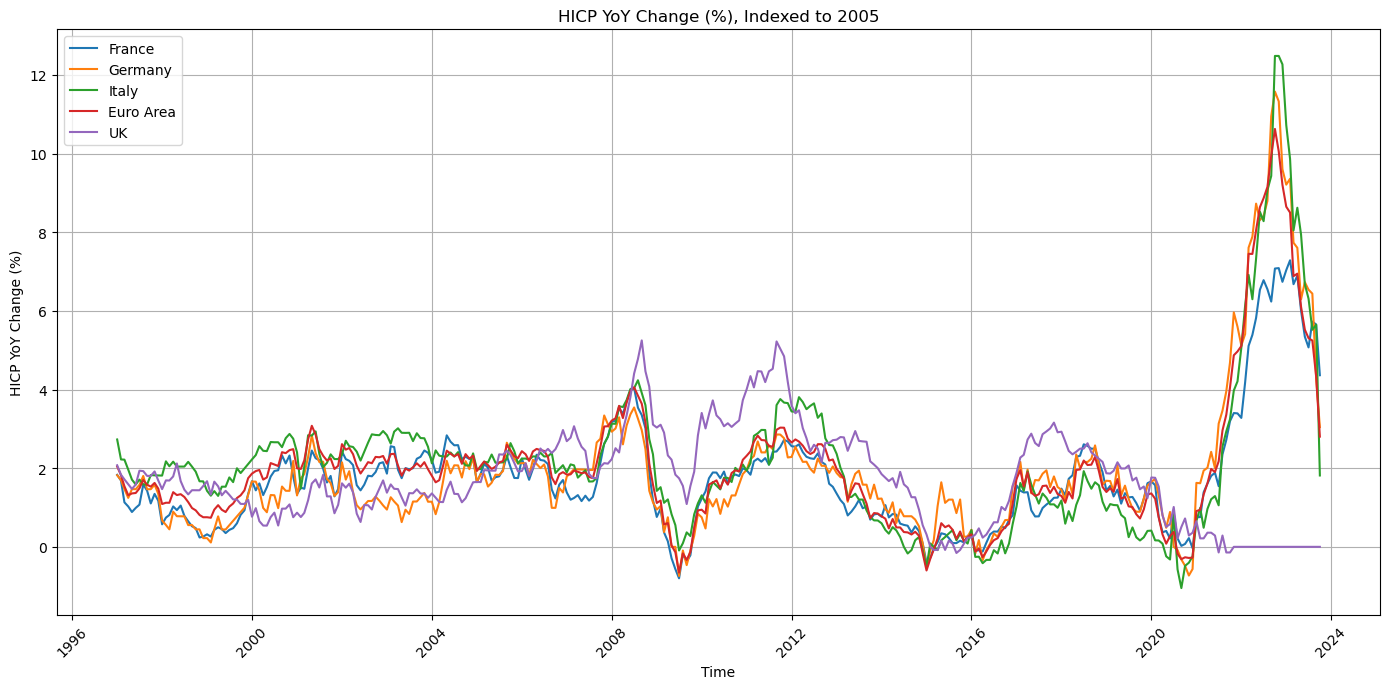

Data not found for Euro Area (EA).


Country,Most Recent Date,Most Recent Value,Previous Year Date,Previous Year Value
France,2023-09-01,16.000000,2022-09-01,17.500000
Germany,2023-09-01,5.800000,2022-09-01,5.900000
Italy,2023-09-01,21.900000,2022-09-01,24.000000
UK,2020-09-01,14.500000,2019-09-01,11.400000


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


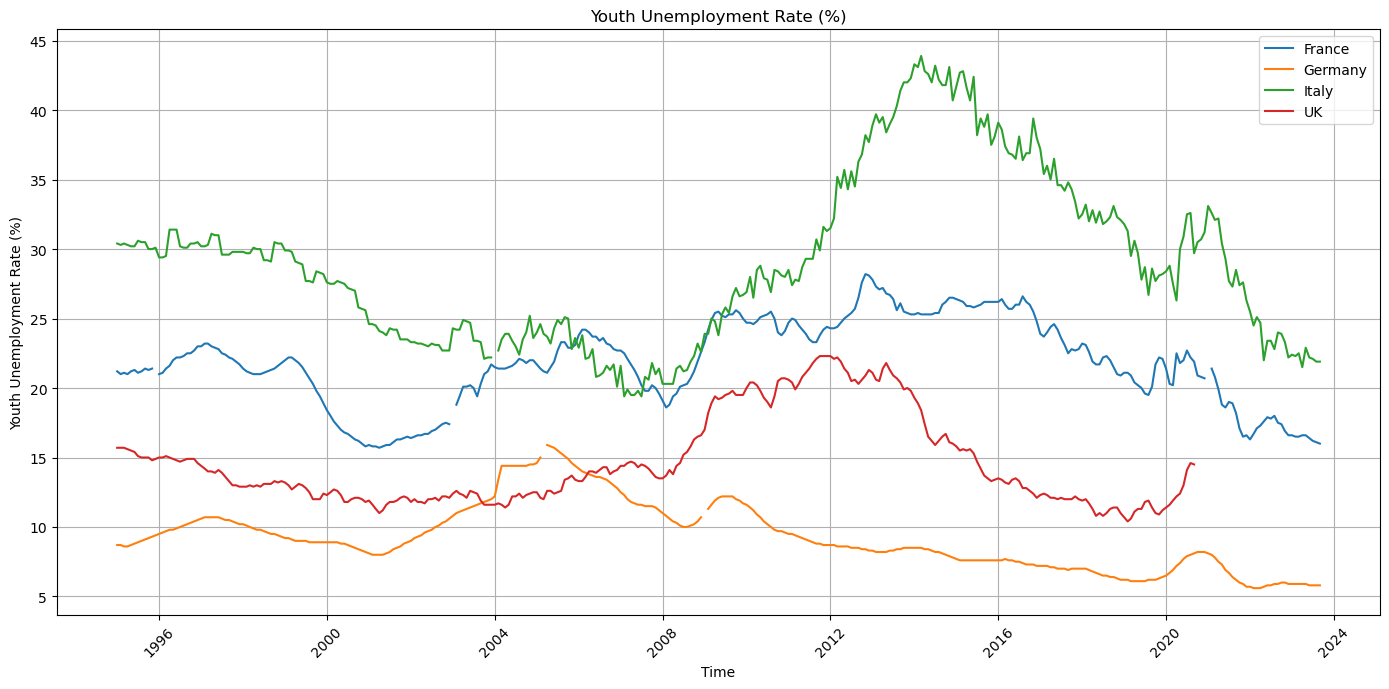

In [138]:
# Loop through the URLs and plot the data
for url_template, title, frequency, x_label, y_label in urls_and_titles:
    fetch_and_plot(url_template, countries, title, frequency, x_label, y_label)